# Travel Planner Assistant 
## LangGraph Nodes Used:
### Orchestrator | Parallelism | Evaluator | (Optional) Human-in-the-Loop

✅ Project Goal:
Create a personalized travel plan by understanding user intent and suggesting top choices for:
1. Flights
2. Hotels
3. Local Attractions
The assistant automates discovery and selection, but can route final suggestions to a human travel expert for approval or customization.




In [ ]:
# Model initialization

from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API _KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


# llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatGroq(
    model="DeepSeek-R1-Distill-Llama-70b",  
)

#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003490904, 'queue_time': 0.045976265999999995, 'total_time': 0.061672722}, 'model_name': 'DeepSeek-R1-Distill-Llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-069d4d01-1b37-4872-a384-14693f7b00ec-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [50]:
from typing import List
from pydantic import BaseModel, Field



# Define the sections of the travel plan
class ItinerarySection(BaseModel):
    name: str = Field(
        description="Category of the itinerary section, such as Flights, Hotels, Attractions, or Notes."
    )
    description: str = Field(
        description="Details about this part of the travel itinerary, including recommendations, bookings, or human suggestions."
    )

# Full travel plan composed of multiple sections
class TravelItinerary(BaseModel):
    sections: List[ItinerarySection] = Field(
        description="Detailed travel plan organized into sections like flights, hotels, attractions, and human feedback."
    )


planner = llm.with_structured_output(TravelItinerary)

In [51]:
from langgraph.constants import Send
from typing import TypedDict, List, Dict
from typing_extensions import Annotated
import operator


class State(TypedDict):
    topic: str # Topic of the report 
    sections: List[ItinerarySection] # List of itinerary sections
    completed_sections: Annotated[List[str], operator.add] # Sections completed by workers
    final_report: str # Final synthesized travel plan
    evaluator_passed: bool # To track if evaluation passed or not

# worker state for generating individual report sections
class WorkerState(TypedDict):
    section: ItinerarySection # A specific section of the travel itinerary
    completed_sections: Annotated[List[str], operator.add]



In [52]:
# Orchestrator: Generates a plan for the travel report
from langchain_core.messages import SystemMessage, HumanMessage
def orchestrator(state: State):
    """ Orchestrator is responsible for generating a plan for travel via dynamically generated workers"""
    travel_plan = planner.invoke(
        [
            SystemMessage(content="Generate a travel plan based on the sections."),
            HumanMessage(content=f"here is the itinerary: {state['topic']}",)
        ]
    )

    print("Travel Plan Sections:", travel_plan)
    # Return the sections of the travel plan
    return {"sections": travel_plan.sections}



In [53]:

# Worker: Writes the content for a section of the itinerary
def llm_call(state: WorkerState):
    """Worker generates content for a specific section of the travel itinerary"""

    # Generate the content for the section using the LLM
    section_content = llm.invoke(
        [
            SystemMessage(
                content="Write a section for the travel plan. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Append the generated section to the completed sections list
    return {"completed_sections": [section_content.content]}

In [54]:

# Evaluator: Evaluate the generated travel plan content
def evaluator(state: State):
    """Evaluates the generated travel plan sections for quality"""

    # Example evaluation logic: Check if each section contains the required level of detail
    evaluation_result = evaluate_content(state["completed_sections"])

    if not evaluation_result:
        # If evaluation fails, return to orchestrator for more work
        print("Evaluation failed, sending back to orchestrator.")
        return Send("orchestrator", state)

    # If evaluation passes, set the evaluator flag and continue
    print("Evaluation passed, proceeding to In-Human.")
    return {"evaluator_passed": True}

def evaluate_content(completed_sections: List[str]) -> bool:
    """Custom function to evaluate the quality of the sections"""

    # Example: Check if sections contain enough content or if certain required details are missing
    for section in completed_sections:
        if len(section.strip()) < 100:  # Example: Section must be at least 50 characters long
            print(f"Evaluation failed: Section too short.")
            return False
        if "details" not in section.lower():  # Example: Section must include the word 'details'
            print(f"Evaluation failed: Missing 'details' in section.")
            return False
    return True

In [55]:
def in_human(state: State):
    """Allow for human adjustments or final review before completing the travel plan"""

    # Collect human feedback or allow for manual adjustments
    human_feedback = collect_human_feedback(state["completed_sections"])

    if not human_feedback:  # If no feedback is provided, return to orchestrator
        print("No feedback received. Returning to orchestrator for further processing.")
        return {"status": "no_feedback", "next_step": "orchestrator"}

    # Apply human feedback to the sections
    updated_sections = apply_human_feedback(state["completed_sections"], human_feedback)

    # Finalize the travel plan with the updated sections
    return {"final_report": "\n\n---\n\n".join(updated_sections), "status": "feedback_applied", "next_step": "synthesizer"}

def collect_human_feedback(completed_sections: List[str]) -> str:
    """Function to collect feedback from a human (e.g., via UI or manual input)"""
    
    # Example logic to collect feedback from a human user
    print("Collecting feedback for the following sections:")

    for i, section in enumerate(completed_sections, 1):
        print(f"{i}. {section[:100]}...")  # Display first 100 chars of each section for review

    # Simulate asking the human for feedback (e.g., via a UI or command-line input)
    feedback = "Ensure that all travel attractions are listed with exact details on opening hours, addresses, and special tips."

    print("Feedback collected:", feedback)
    return feedback

def apply_human_feedback(completed_sections: List[str], feedback: str) -> List[str]:
    """Apply human feedback to the completed sections"""
    
    # Example logic: Append the feedback to the last section or modify sections as required
    print(f"Applying feedback: {feedback}")
    completed_sections[-1] += f"\n\nHuman Feedback: {feedback}"
    return completed_sections


In [56]:
# Synthesizer: Combines all completed sections into a full travel plan
def synthesizer(state: State):
    """Combine all completed sections into a full travel plan"""

    # Gather all completed sections
    completed_sections = state["completed_sections"]

    # Join the sections together with markdown formatting
    completed_travel_plan = "\n\n---\n\n".join(completed_sections)

    # Return the final synthesized travel plan
    return {"final_report": completed_travel_plan}



In [57]:
# Conditional edge function to create llm_call workers that each write a section of the travel itinerary
def assign_workers(state: State):
    """Assign a worker to each section in the travel plan"""

    # Send tasks to workers to generate content for each section in parallel
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [58]:
# Graph Bulding
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

orchestrator_graph_builder = StateGraph(State)

orchestrator_graph_builder.add_node(
    "orchestrator",
    orchestrator,
)
orchestrator_graph_builder.add_node(
    "llm_call",
    llm_call,
)
orchestrator_graph_builder.add_node(
    "synthesizer",
    synthesizer,
)
orchestrator_graph_builder.add_node(
    "evaluator",
    evaluator,
)
orchestrator_graph_builder.add_node(
    "in_human",
    in_human,
)



orchestrator_graph_builder.add_edge(
    START,
    "orchestrator",
)
orchestrator_graph_builder.add_conditional_edges(
    "orchestrator", 
    assign_workers, 
    ["llm_call"]
)
orchestrator_graph_builder.add_edge(
    "llm_call",
    "evaluator",
)
orchestrator_graph_builder.add_conditional_edges(
    "evaluator",
    evaluate_content,
    "orchestrator",
    # condition=lambda state: state.get('evaluation_status') == False
)
orchestrator_graph_builder.add_edge(
    "evaluator",
    "in_human",
    # condition=lambda state: state.get('evaluation_status') == True
)
orchestrator_graph_builder.add_conditional_edges(
    "in_human",
    in_human,  
    "orchestrator", 
    # condition=lambda state: state.get('status') == 'no_feedback'
)
orchestrator_graph_builder.add_edge(
    "in_human",
    "synthesizer",
    # condition=lambda state: state.get('status') == 'feedback_applied'
)
orchestrator_graph_builder.add_edge(
    "synthesizer",
    END,
)

# compile the workflow
travel_agent = orchestrator_graph_builder.compile()

# Run the workflow
state = travel_agent.invoke(
    {
        "topic": "Travel Itinerary for a trip to Paris",
    }
)

# Display the final report
print("Final Report:", state["final_report"])
# Display the grap

Travel Plan Sections: sections=[ItinerarySection(name='Flights', description='Flight from New York to Paris on Air France, departing at 8:00 PM, arriving at 7:30 AM the next day.'), ItinerarySection(name='Hotels', description='Stay at Hotel Le Marais in the heart of Paris, booked for 5 nights.'), ItinerarySection(name='Attractions', description='Visit the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral.'), ItinerarySection(name='Transportation', description='Take a taxi from the airport to the hotel and use the Paris Metro for getting around the city.'), ItinerarySection(name='Food', description='Dine at a traditional French bistro and try local cuisine like escargots and croissants.'), ItinerarySection(name='Notes', description="Don't forget to validate your train tickets before boarding and enjoy the street performers at Montmartre.")]
Evaluation failed: Missing 'details' in section.
Evaluation failed, sending back to orchestrator.
Evaluation failed: Section too short.
1. <thin

In [59]:
print(state["final_report"])

<think>
Alright, so the user has provided a query where they want me to write a section for a travel plan. They specified the section name as "Flights" and gave a description: a flight from New York to Paris on Air France, departing at 8 PM and arriving at 7:30 AM the next day.

First, I need to understand the context. It seems like the user is creating a travel itinerary and needs a specific section formatted. They mentioned using markdown, so I should structure it with headers and bullet points.

I notice that the user also included an example response in their query. That gives me a clear idea of the desired format. They used a header with "## Flights" and then a bullet point with the details. I should follow that structure.

I should make sure to include all the details they provided: departure city, arrival city, airline, departure time, arrival time, and the duration. Calculating the duration is important, so I'll add that as approximately 8 hours and 30 minutes.

I also need to 

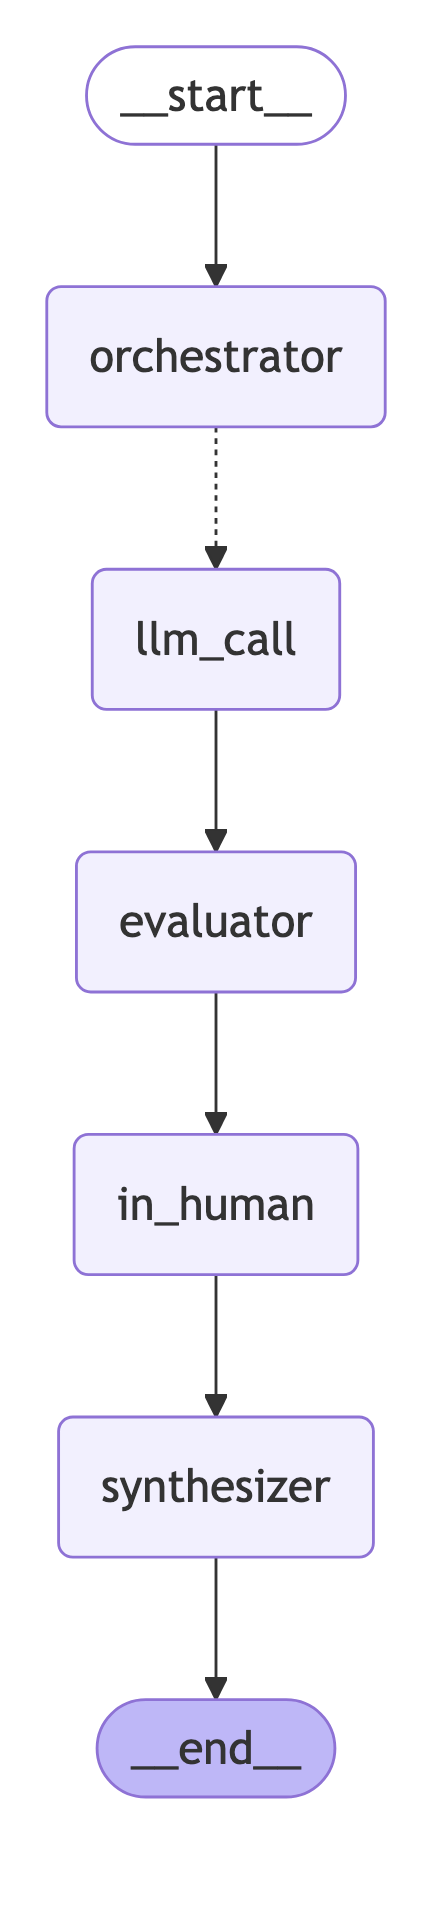

In [60]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        travel_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,
        )
    )
)

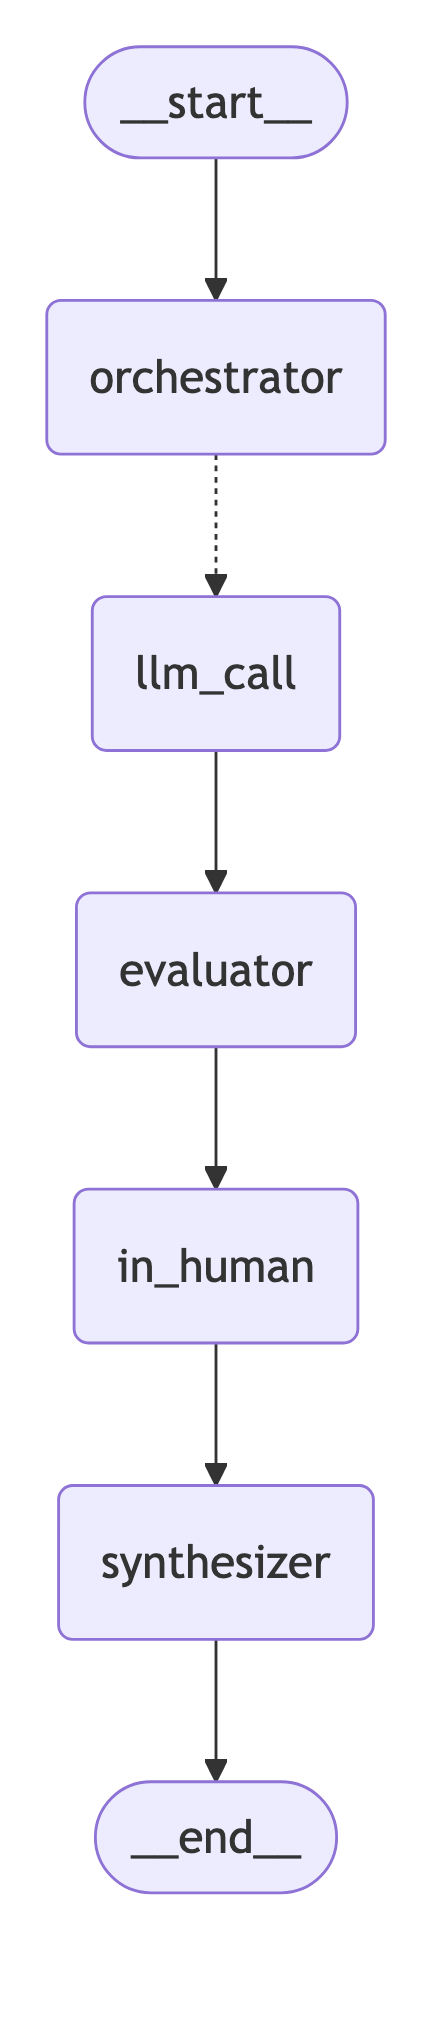

In [61]:
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        travel_agent.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)